In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from skimage import io, exposure, transform
import cv2 as cv
import yaml

In [4]:
main_dir = '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly'

# Get explainer training config

In [27]:
config = os.path.join(main_dir, 'configs/Step_4_MIMIC_Explainer_256_Cardiomegaly.yaml')
config = yaml.load(open(config))
for k in config.keys():
    print(k, config[k])

('cls_experiment', 'output/classifier/StanfordCheXpert_256')
('suffix', '_train_set_50')
('image_dir', '')
('count_to_save', 50)
('names_to_save', '')
('lambda_cls', 1)
('cls_loss_type', 'kl')
('batch_size', 8)
('num_channel', 1)
('epochs', 300)
('unet_loss_type', 'weighted')
('unet_experiment', 'output/segmentation/JSRT_256/Lung/ckpt_dir')
('img_to_save', '')
('discriminator_type', 'Discriminator_Ordinal')
('target_class', 3)
('save_summary', 500)
('crop_size', 225)
('num_class', 14)
('name', 'Explainer_MIMIC_Cardiomegaly')
('ckpt_dir_continue', 'output/classifier/StanfordCheXpert_256/Explainer_MIMIC_Cardiomegaly')
('test_dir', '')
('feature', False)
('seed', 0)
('lambda_GAN', 1)
('log_dir', 'output/classifier/StanfordCheXpert_256')
('feature_names', 'dense_4')
('input_size', 256)
('image_label_dict', 'output/classifier/StanfordCheXpert_256/Explainer_MIMIC_Cardiomegaly/list_attr_Cardiomegaly.txt')
('num_bins', 10)
('lambda_cyc', 100)


In [28]:
config['disease_name'] = 'cardiomegaly'

# Read explainer output data

In [29]:
output_dir = os.path.join(main_dir, config['log_dir'], config['name'])

In [30]:
test_dir = os.path.join(output_dir, 'test'  )
names = np.load(os.path.join(test_dir, 'names'+config['suffix']+'.npy'))
real_img = np.load(os.path.join(test_dir, 'real_img'+config['suffix']+'.npy'))
fake_img = np.load(os.path.join(test_dir, 'fake_img'+config['suffix']+'.npy'))
real_pred = np.load(os.path.join(test_dir, 'real_pred'+config['suffix']+'.npy'))
fake_pred = np.load(os.path.join(test_dir, 'fake_pred'+config['suffix']+'.npy'))
real_seg = np.load(os.path.join(test_dir, 'real_seg'+config['suffix']+'.npy'))
fake_seg = np.load(os.path.join(test_dir, 'fake_seg'+config['suffix']+'.npy'))
print(names.shape, real_img.shape, fake_img.shape, real_pred.shape, fake_pred.shape, real_seg.shape, fake_seg.shape)
fake_img = np.reshape(fake_img, [-1, config['num_bins'], config['input_size'], config['input_size'], config['num_channel']])
real_pred = np.reshape(real_pred, [-1, config['num_bins'], config['num_class']])
real_pred = np.mean(real_pred, axis=1)
fake_pred = np.reshape(fake_pred, [-1, config['num_bins'], config['num_class']])
real_seg = np.reshape(real_seg, [-1, config['num_bins'], config['input_size'], config['input_size'], config['num_channel']])
real_seg = np.mean(real_seg, axis=1)
fake_seg = np.reshape(fake_seg, [-1, config['num_bins'], config['input_size'], config['input_size'], config['num_channel']])
print(names.shape, real_img.shape, fake_img.shape, real_pred.shape, fake_pred.shape, real_seg.shape, fake_seg.shape)

((52,), (52, 256, 256, 1), (520, 256, 256, 1), (520, 14), (520, 14), (520, 256, 256, 1), (520, 256, 256, 1))
((52,), (52, 256, 256, 1), (52, 10, 256, 256, 1), (52, 14), (52, 10, 14), (52, 256, 256, 1), (52, 10, 256, 256, 1))


# Read a Keras segmentor for lung and heart

In [31]:
import keras.models as models
from keras.models import Model
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, concatenate
from keras.layers import Conv2D, Conv2DTranspose
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.regularizers import l2
np.random.seed(7)
import math
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [32]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet():
# down
    filters = 64
    input_layer = Input(shape=(256, 256, 1), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=2, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [11]:
model = Unet()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
from keras.models import load_model
model_path = 'output/segmentation/JSRT_256/Lung_Heart/ckpt_dir/model_Segmentation_Lung_Heart_JSRT.050.hdf5'
model_path = os.path.join(main_dir, model_path)
model = load_model(model_path)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Visualize  Qualitative Results

In [13]:
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
from skimage import morphology


In [14]:
def compute_ctr(heart,lung):
    lung_index = np.sum(lung,axis=0)
    values = np.where(lung_index>80)
    lung_min_x, lung_max_x = np.min(values), np.max(values)
    lung_width = lung_max_x - lung_min_x
    heart_index = np.sum(heart,axis=0)
    values = np.where(heart_index>80)
    heart_min_x = np.min(values)
    heart_max_x = np.max(values)
    heart_width = heart_max_x - heart_min_x
    ctr = float(heart_width)/lung_width
    return(ctr, [(lung_min_x,200), (lung_max_x,200), (heart_min_x,200), \
                 (heart_max_x,200)])

def inverse_image(img): 
    img = (img + 1.) * 127.5
    img[img > 255] = 255.
    img[img < 0] = 0.
    return img.astype(np.uint8)

def get_new_image(img, mask, heart):
    img = inverse_image(img)
    heart[heart!=0]=1
    heart_d = morphology.dilation(heart)
    heart_d = morphology.dilation(heart_d)
    heart_d = morphology.dilation(heart_d)
    boundary_heart = heart_d - heart
    boundary_heart[boundary_heart!=0]=1
    
    g_channel = np.copy(img)
    b_channel = np.copy(img)
    img[boundary_heart == 1] = 255
    g_channel[boundary_heart == 1] = 255
    b_channel[boundary_heart == 1] = 0
    I = np.dstack([img, g_channel, b_channel])
    return I

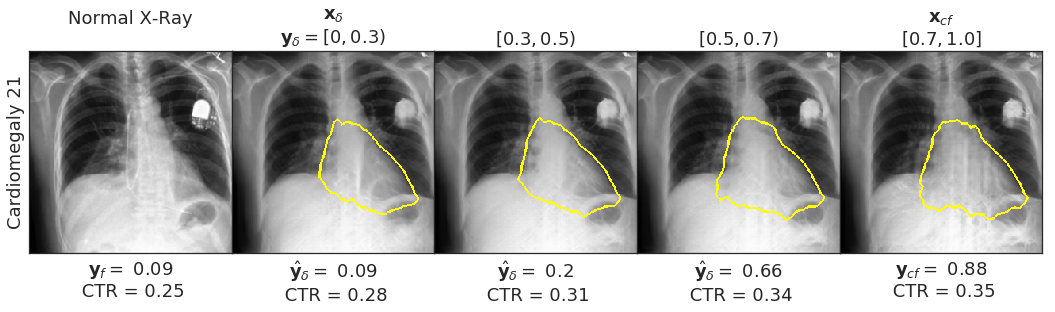

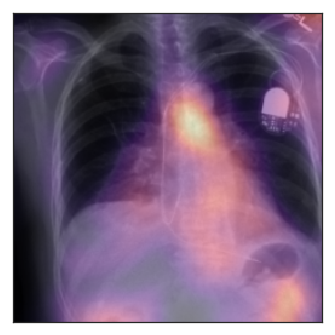

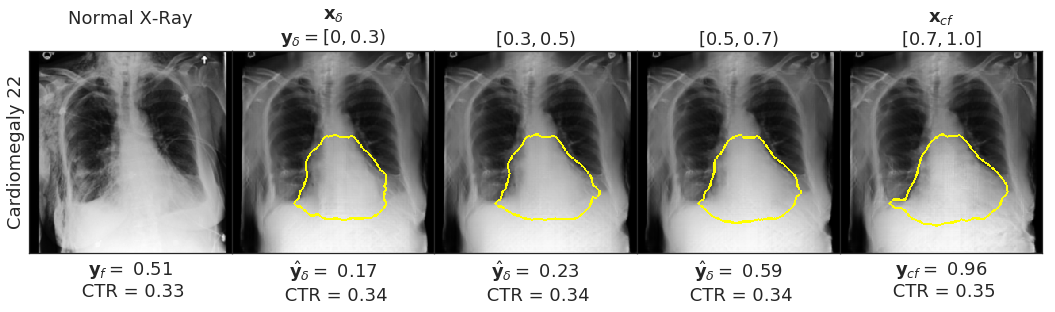

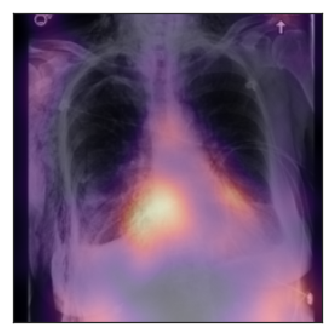

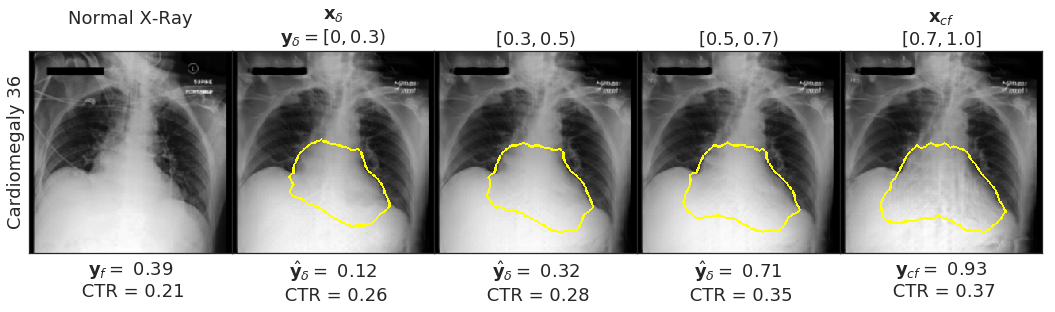

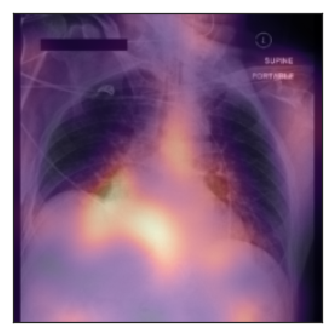

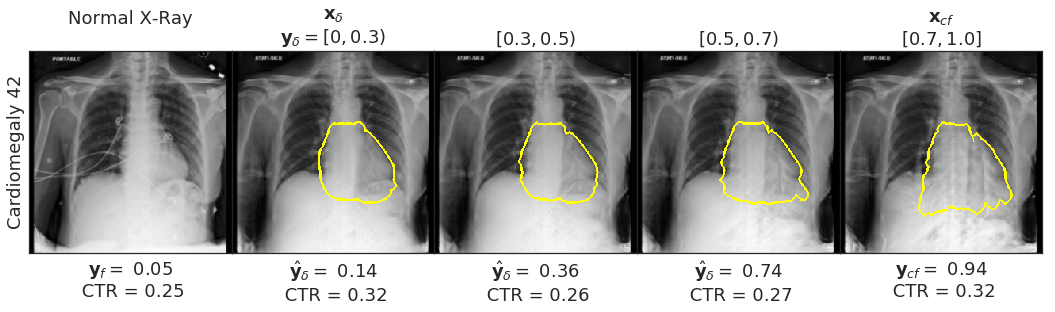

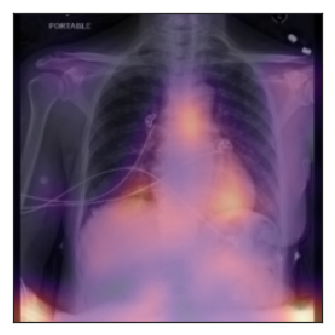

In [74]:
sns.set(color_codes=True)
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
title = ['Normal X-Ray\n', '$\mathbf{x}_{\delta}$' + '\n' + '$\mathbf{y}_{\delta} = [0, 0.3)$',\
         '' + '\n' + '$ [0.3, 0.5)$', '' + '\n' + '$ [0.5, 0.7)$', '$\mathbf{x}_{cf}$' + '\n' + '$[0.7, 1.0]$']
cols = 5
for ii in [21,22,36,42]: 
    fig,ax = plt.subplots(1,cols,figsize=(15,5))
    ax_index = 0
    for j in [10,1,3,6,9]:
        if j == 10:
            im = real_img[ii,:,:,:]
        else:
            im = fake_img[ii,j,:,:,:]
        IMGS = np.reshape(im, [1,256,256,1])
        mask = model.predict(IMGS)
        
        ax[ax_index].imshow(IMGS[0,:,:,0],cmap='gray')
        ax[ax_index].set_xticks([])
        ax[ax_index].set_yticks([])
        ax[ax_index].set_title(title[ax_index])
        
        lung = mask[0,:,:,0]
        heart = mask[0,:,:,1]
        lung[lung>0.8]=1
        lung[lung!=1]=0
        heart[heart>0.8]=1
        heart[heart!=1]=0
        heart = heart.astype(bool)
        a = morphology.remove_small_objects(heart)
        a = morphology.remove_small_objects(a, min_size = 300)
        a = morphology.remove_small_objects(a)
        a = morphology.remove_small_objects(a)
        heart_a = a.astype(int)
        a1 = morphology.binary_dilation(heart_a)
        a2 = morphology.binary_dilation(a1)
        heart = heart_a+a1+a2
        lung = lung.astype(bool)
        a = morphology.remove_small_objects(lung)
        a = morphology.remove_small_objects(a, min_size = 300)
        a = morphology.remove_small_objects(a)
        lung_a = a.astype(int)
        a1 = morphology.binary_dilation(lung_a)
        a2 = morphology.binary_dilation(a1)
        lung = lung_a+a1+a2
        edges_pz = get_new_image(IMGS[0,:,:,0],lung, heart)
        if j!= 10:
            ax[ax_index].imshow(edges_pz)
        try:
            ctr, points = compute_ctr(heart,lung)
        except:
            ctr=0.0
        if ax_index == 0:
            ax[ax_index].set_ylabel('Cardiomegaly ' + str(ii))
            ax[ax_index].set_xlabel('$\mathbf{y}_f = $ ' + str(np.round(real_pred[ii][3],2)) +\
                                   '\n CTR = ' + str(np.round(ctr,2)))
        elif ax_index == 4:
            ax[ax_index].set_xlabel('$\mathbf{y}_{cf} =$ ' + \
                                    str(np.round(fake_pred[ii][j][3],2)) +\
                                   '\n CTR = ' + str(np.round(ctr,2)))
        else:
            ax[ax_index].set_xlabel('$\hat{\mathbf{y}}_{\delta} =$ ' + \
                                    str(np.round(fake_pred[ii][j][3],2)) +\
                                   '\n CTR = ' + str(np.round(ctr,2)))
        ax_index+=1
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()
    img_to_show = np.abs(fake_img[ii,1,:,:,0]-fake_img[ii,9,:,:,0])
    img_to_show[img_to_show> 0.45]=0.45
    df3_smooth= gaussian_filter(img_to_show, sigma=10)
    plt.imshow(real_img[ii,:,:,0], cmap ='gray')
    plt.imshow(df3_smooth,cmap ='magma',alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

# Test: Generated images are fooling the classifier

In [16]:
main_index = config['target_class']
print(real_pred.shape, fake_pred.shape)
bins =  np.asarray(real_pred[:,main_index]*config['num_bins']).astype(int)
print(bins.shape)
print(np.unique(bins,return_counts=True))
print(np.min(np.unique(bins,return_counts=True)[1]))
fake_pred = np.reshape(fake_pred, [-1,config['num_class']])
print(real_pred.shape, fake_pred.shape)

((52, 14), (52, 10, 14))
(52,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 5,  6,  2,  7,  3,  5,  5,  3, 10,  6]))
2
((52, 14), (520, 14))


In [26]:
target_bin = np.tile(np.asarray(range(config['num_bins'])),bins.shape[0])
source_bin = np.repeat(bins, repeats=config['num_bins'])
source_pred = np.repeat(real_pred[:,main_index], repeats=config['num_bins'])
target_pred = fake_pred[:,main_index]
delta = target_bin-source_bin
print(target_bin.shape, source_bin.shape, source_pred.shape,target_pred.shape,delta.shape)
print(np.min(delta), np.max(delta))

((1640,), (1640,), (1640,), (1640,), (1640,))
(-9, 9)


/ocean/projects/asc170022p/singla/anaconda/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


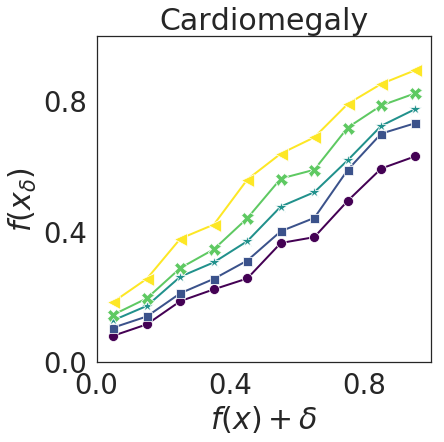

In [29]:
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2})
from matplotlib import cm
colors = cm.get_cmap('viridis', 5)
newcolors = colors(np.linspace(0, 1, 5))

real_p = target_bin * 0.1
real_p_ = (target_bin+1) * 0.1
real_p = (real_p + real_p_)/2
fake_q = target_pred
fig = plt.figure(figsize = (6,6))
names = ['0.0-0.2', '', '0.2-0.4', '0.30-0.40', '0.4-0.6', '0.50-0.60', \
         '0.6-0.8', '0.70-0.80', '0.8-1.0', '0.90-1.00']
makrker_size = [10,0,9,0,13,0,13,0,13,0]
markers = ['o', '','s','','*', '','X', 'X', '<', '>', 's', '*', 'D', 'd', 'X']
x = np.arange(0.0, 1.0, step=0.1)
#plt.plot(x, x,c='black',linestyle='dashed',alpha=0.5) # dashdot black
for i in range(0,config['num_bins'],2):
    index = np.where(source_bin == i)
    target_pred_i = fake_q[index]
    source_pred_i = real_p[index]
    index = np.where(source_bin == i+1)
    target_pred_i = np.append(target_pred_i, fake_q[index],axis=0)
    source_pred_i = np.append(source_pred_i,real_p[index],axis=0)
    target_pred_i = np.reshape(target_pred_i,[-1,config['num_bins']])
    source_pred_i = np.reshape(source_pred_i,[-1,config['num_bins']])
    mean_t = np.mean(target_pred_i,0)
    sd_t = np.std(target_pred_i,0)           
    mean_s = np.mean(source_pred_i,0)
    sd_s = np.std(source_pred_i,0)
    x_axis = np.arange(0.0, 1.0, step=0.1)
    ax = sns.lineplot(mean_s,mean_t,label=names[i],c=newcolors[int(i/2)],\
                              alpha=1,marker=markers[i], markersize=makrker_size[i])
plt.xticks(np.arange(0, 1.1, step=0.2))
plt.yticks(np.arange(0, 1.1, step=0.2))
ax.get_legend().remove()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.xlabel( r'$f(x)+\delta$' )
plt.ylabel(r'$f(x_{\delta})$')
plt.title('Cardiomegaly')
plt.show()

In [30]:
real_pred.shape, fake_pred.shape

((164, 14), (1640, 14))

In [32]:
fake_pred = np.reshape(fake_pred, [-1, config['num_bins'], config['num_class']])

In [33]:
real_pred.shape, fake_pred.shape

((164, 14), (164, 10, 14))

# Visualize as gif

In [23]:
# choose samples to be saved
samples = [18]

In [24]:
import cv2
import imageio
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

i =0
temp_dir = os.path.join(main_dir, output_dir, 'gif')
try:
    os.makedirs(temp_dir)
    os.makedirs(os.path.join(temp_dir,'tmp','img_original'))
    os.makedirs(os.path.join(temp_dir,'tmp','img'))                
except:
    pass


fig = plt.figure()
for index in samples:
    plt.imshow(real_img[index,:,:,0],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    cu_pre = str(np.round(real_pred[index][config['target_class']],
                          decimals=2))
    plt.title('$f(x)$=' + cu_pre)
    fig.savefig(temp_dir + "/tmp/img_original/example_"+config['disease_name']+
                "_index_" + str(index)+".png",\
                    bbox_inches='tight')
    plt.close()


    for j in range(9,-1,-1):
        fig, (ax, ax3) = plt.subplots(1,2, sharey=False,figsize=(13,5))
        img = fake_img[index,j,:,:,0]
        img = np.interp(img, [-1,1], [0,255])
        ax.imshow(img, cmap='gray') 
        ax.set_xticks([])
        ax.set_yticks([])

        ax3.set_ylabel(r'$p($Normal$ | x)$')
        ax3.set_ylim([0.0,1.1])    
        ax3.set_xlim([0,1.1])
        x = []
        y = []
        for k in range(9,j-1,-1):
            value = np.round(fake_pred[index,k,config['target_class']],decimals=2)
            x.append(1-k*0.1)
            y.append(1-value)
        ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax3.plot(x,y,  color='k',marker='o')
        ax3.tick_params(axis='y', colors='k')
        ax3.yaxis.label.set_color('k')              
        ax3.set_xticks([])

        #plt.show()
        fig.savefig(temp_dir+"/tmp/img/example_"+config['disease_name']+ "_" +
                    str(j)+ "_index_" \
                    + str(index)+".png",bbox_inches='tight')
        plt.close()
        #break
    with imageio.get_writer(temp_dir+'/'+config['disease_name']+'_'+cu_pre+'_'+str(index)+'.gif', mode='I') as writer:
        if float(cu_pre) > 0.5:
            for ii in range(9,-1,-1):
                filename = temp_dir+'/tmp/img/example_'+config['disease_name']+'_'+str(ii)+'_index_'+str(index)+'.png'
                image = imageio.imread(filename)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
        else:
            for ii in range(0,10):
                filename = temp_dir+'/tmp/img/example_'+config['disease_name']+'_'+str(ii)+'_index_'+str(index)+'.png'
                image = imageio.imread(filename)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)

# Generate gif with segmentation

In [70]:
samples = [48]

In [71]:
import cv2
import imageio
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
i =0
fig = plt.figure()
for index in samples:
    plt.imshow(real_img[index,:,:,0],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    cu_pre = str(np.round(real_pred[index][config['target_class']],
                          decimals=2))
    plt.title('$f(x)$=' + cu_pre)
    fig.savefig(temp_dir + "/tmp/img_original/example_"+config['disease_name']+
                "_index_" + str(index)+".png",\
                    bbox_inches='tight')
    plt.close()


    for j in range(9,0,-1):
        fig, (ax, ax3) = plt.subplots(1,2, sharey=False,figsize=(13,5))
        img = fake_img[index,j,:,:,0]
        IMGS = np.reshape(img, [1,256,256,1])
        mask = model.predict(IMGS)
        lung = mask[0,:,:,0]
        heart = mask[0,:,:,1]
        lung[lung>0.8]=1
        lung[lung!=1]=0
        heart[heart>0.8]=1
        heart[heart!=1]=0
        heart = heart.astype(bool)
        a = morphology.remove_small_objects(heart)
        a = morphology.remove_small_objects(a, min_size = 400)
        a = morphology.remove_small_objects(a)
        a = morphology.remove_small_objects(a)
        heart_a = a.astype(int)
        a1 = morphology.binary_dilation(heart_a)
        a2 = morphology.binary_dilation(a1)
        heart = heart_a+a1+a2
        lung = lung.astype(bool)
        a = morphology.remove_small_objects(lung)
        a = morphology.remove_small_objects(a, min_size = 400)
        a = morphology.remove_small_objects(a)
        a = morphology.remove_small_objects(a)
        lung_a = a.astype(int)
        a1 = morphology.binary_dilation(lung_a)
        a2 = morphology.binary_dilation(a1)
        lung = lung_a+a1+a2
        edges_pz = get_new_image(IMGS[0,:,:,0],lung, heart)
        ax.imshow(edges_pz) 
        ax.set_xticks([])
        ax.set_yticks([])

        ax3.set_ylabel(r'$p($Normal$ | x)$')
        ax3.set_ylim([0.0,1.1])    
        ax3.set_xlim([0,1.1])
        x = []
        y = []
        for k in range(9,j-1,-1):
            value = np.round(fake_pred[index,k,config['target_class']],decimals=2)
            x.append(1-k*0.1)
            y.append(1-value)
        ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax3.plot(x,y,  color='k',marker='o')
        ax3.tick_params(axis='y', colors='k')
        ax3.yaxis.label.set_color('k')              
        ax3.set_xticks([])

        #plt.show()
        fig.savefig(temp_dir+"/tmp/img/example_"+config['disease_name']+ "_" +
                    str(j)+ "_index_" \
                    + str(index)+".png",bbox_inches='tight')
        plt.close()
        #break
    with imageio.get_writer(temp_dir+'/'+config['disease_name']+'_'+cu_pre+'_seg_'+str(index)+'.gif') as writer:
        if float(cu_pre) > 0.5:
            for ii in range(9,0,-1):
                filename = temp_dir+'/tmp/img/example_'+config['disease_name']+'_'+str(ii)+'_index_'+str(index)+'.png'
                image = imageio.imread(filename)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
        else:
            for ii in range(1,10):
                filename = temp_dir+'/tmp/img/example_'+config['disease_name']+'_'+str(ii)+'_index_'+str(index)+'.png'
                image = imageio.imread(filename)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)
                writer.append_data(image)